# Import Library

In [1]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import mean_absolute_error

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Dataset

In [2]:
X = pd.read_csv("dataset/train_features.csv")
y = pd.read_csv("dataset/train_label.csv")
testData = pd.read_csv("dataset/test_feature.csv")
submission_format = pd.read_csv("dataset/submission_format.csv")

### Berikut merupakan dataset yang akan digunakan untuk memprediksi harga suatu hotel, berikut penjelasan setiap kolom:
* facilities: Kolom ini berisikan fasilitas apa saja yang terdapat pada hotel tersebut, namun dapat dilihat datanya kurang konsisten seperti tidak ada spasi, penggunaan huruf besar dan kecil juga acak, lalu terdapat fasilitas yang salah tulis seperti 'intrnet' yang seharusnya 'internet'
* rating: Kolom ini berisikan beberapa informasi seperti berapa rata-rata penilaian dari orang, kemudian berapa jumlah orang yang melakukan penilaian
* location: Kolom ini berisikan lokasi hotel tersebut

In [3]:
X.head()

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol


In [4]:
y.head()

,Price
0,"13,500avg/night"
1,"13,000avg/night"
2,"19,000avg/night"
3,"6,000avg/night"
4,"20,000avg/night"


### Dapat dilihat dari data di atas, terdapat satuan (avg/night) dan delimiter (,) yang harus dihilangkan dan diubah tipe datanya menjadi integer agar data dapat dengan mudah diolah

In [5]:
y['Price'] = y['Price'].str.replace('avg/night', '')
y['Price'] = y['Price'].str.replace(',', '')
y['Price'] = y['Price'].astype(int)

### Sebelum melakukan pembersihan data, *dataset* X yang berisikan *independent variable* dan *dataset* y yang berisikan *dependent variable* digabung, hal itu bertujuan agar ketika terdapat beberapa baris yang dihilangkan, maka jumlah baris *dataset* X dan y tetap sama

In [6]:
new_df = pd.concat([X, y], axis=1)

# Explore the Dataset

### *Dataset* X, terdiri dari 5 kolom fitur, 1 kolom target *(Price)* dan 3066 baris data, yang mana terdapat beberapa tipe data seperti int64 dan object. Dapat dilihat juga jumlah data yang non-null pada setiap kolomnya

In [7]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 95.9+ KB


## Berikut merupakan persebaran harga hotel, dapat dilihat distribusinya jauh dari kata normal, hal itu dikarenakan terdapat *outliers* yang sebaiknya dihilangkan

<AxesSubplot: xlabel='Price', ylabel='Density'>

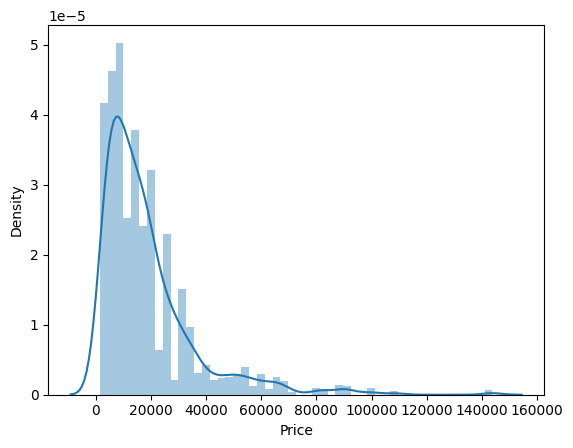

In [8]:
sns.distplot(new_df['Price'])

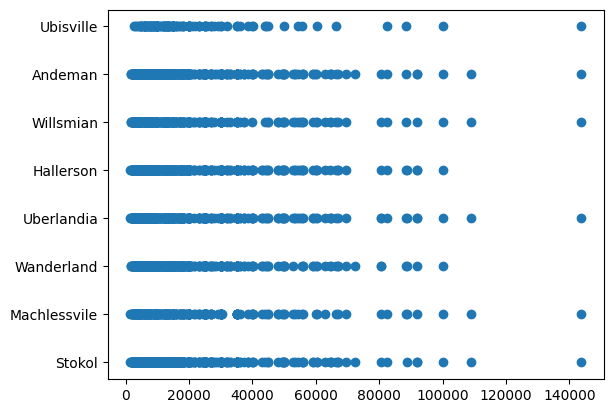

In [9]:
plt.scatter(new_df['Price'], new_df['location'])
plt.show()

### Kode di bawah akan menampilkan jumlah data yang bernilai null pada setiap kolom yang ada, diurutkan dari yang terbesar hingga terkecil. Selanjutnya akan dilakukan *data preprocessing* khususnya kolom 'rating' dan 'facilities' agar data lebih mudah diolah ke dalam model

In [10]:
print(new_df.isna().sum().sort_values(ascending = False))

rating        637
facilities    301
location        0
Price           0
dtype: int64


# Data Preprocessing

In [11]:
# Mengambil angka terdepan pada kolom rating dengan bantuan regex
new_df['Rating'] = new_df['rating'].str.extract(r'(\d+\.\d)')

#  Mengambil angka pada kolom rating dengan bantuan regex
new_df['NumReviews'] = new_df['rating'].str.extract(r'(\d+) review')

# Mengisi nilai yang kosong pada kolom fasilitas dengan 'Unknown' agar dapat diolah
new_df['facilities'].fillna('Unknown', inplace=True)
    
# Menghitung jumlah fasilitas yang ada
new_df['Restaurant'] = new_df['facilities'].str.lower().str.contains('res').astype(int)
new_df['Internet'] = new_df['facilities'].str.lower().str.contains('net').astype(int)
new_df['Bar'] = new_df['facilities'].str.lower().str.contains('bar').astype(int)
new_df['Pool'] = new_df['facilities'].str.lower().str.contains('pool').astype(int)
new_df['Gym'] = new_df['facilities'].str.lower().str.contains('gym').astype(int)
new_df['Facilities'] = new_df[['Restaurant', 'Internet', 'Bar', 'Pool', 'Gym']].sum(axis=1)

# Drop kolom yang tidak terpakai
fix_df = new_df.drop(['facilities', 'rating', 'Restaurant', 'Internet', 'Bar', 'Pool', 'Gym'], axis=1)

# Mengubah tipe data serta melakukan rename pada kolom agar penamaannya konsisten
fix_df['Rating'] = fix_df['Rating'].astype('Float64')
fix_df['NumReviews'] = fix_df['NumReviews'].astype('Int64')
fix_df['location'] = fix_df['location'].astype('category')
fix_df = fix_df.rename(columns={'location': 'Location'})

# Remove outlier
fix_df = fix_df.drop(fix_df[fix_df['NumReviews'] > 50].index)
fix_df = fix_df.drop(fix_df[fix_df['Price'] > 50000].index)

# Fill or Drop Null value
fix_df['Rating'].fillna(0.0, inplace=True)
fix_df = fix_df.interpolate(method ='pad', limit_direction ='forward')
fix_df = fix_df.dropna()

fix_df

,Location,Price,Rating,NumReviews,Facilities
0,Stokol,13500,7.8,10,3
1,Machlessvile,13000,5.6,4,3
2,Wanderland,19000,7.2,38,4
3,Uberlandia,6000,7.3,6,2
4,Stokol,20000,7.2,30,2
...,...,...,...,...,...
3061,Andeman,31625,0.0,3,2
3062,Uberlandia,30500,8.1,4,3
3063,Willsmian,14000,6.7,10,3
3064,Hallerson,8500,0.0,10,1


### Di bawah merupakan jumlah fasilitas pada setiap hotel yang ada, dapat dilihat bahwa jumlah fasilitas terdistribusi normal

<AxesSubplot: title={'center': 'Jumlah Fasilitas pada Hotel'}, ylabel='Facilities'>

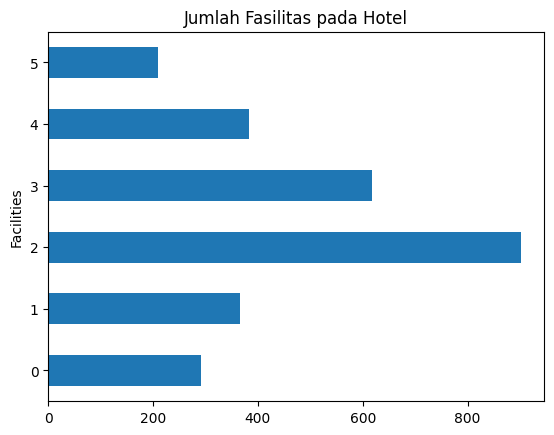

In [12]:
fix_df.value_counts('Facilities').sort_index().plot(kind='barh', title='Jumlah Fasilitas pada Hotel')

In [13]:
fix_df.describe()

,Price,Rating,NumReviews,Facilities
count,2767.000000,2767.0,2767.0,2767.000000
mean,15102.120708,5.607915,12.111312,2.383448
std,10677.895439,3.259273,12.60596,1.365329
min,1500.000000,0.0,1.0,0.000000
25%,7000.000000,4.2,3.0,2.000000
50%,12800.000000,6.9,7.0,2.000000
75%,20000.000000,7.9,17.0,3.000000
max,50000.000000,10.0,50.0,5.000000


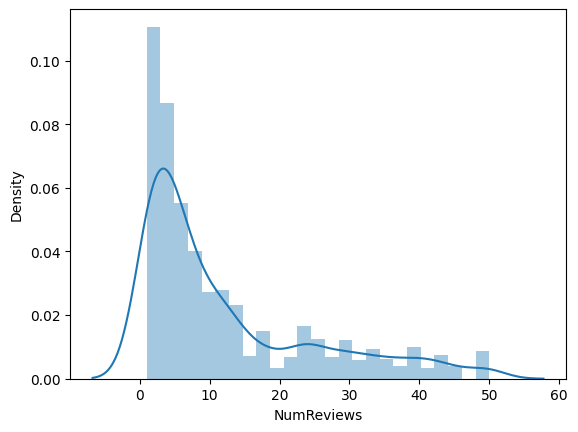

In [14]:
sns.distplot(fix_df['NumReviews']);

<AxesSubplot: xlabel='Price', ylabel='Density'>

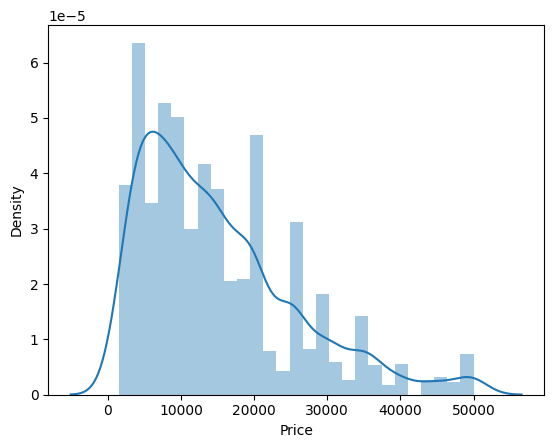

In [15]:
sns.distplot(fix_df['Price'])

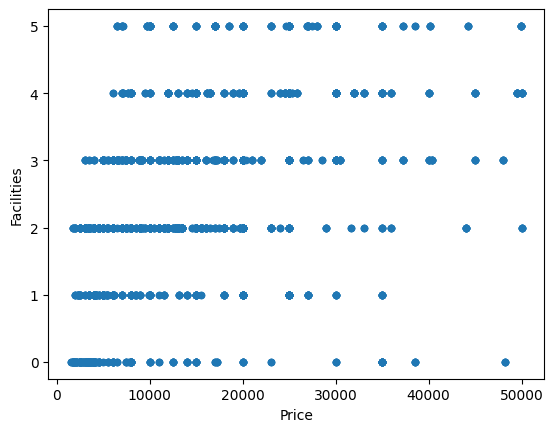

In [16]:
fix_df.plot.scatter(x='Price', y='Facilities')
# Display the plot
plt.show()

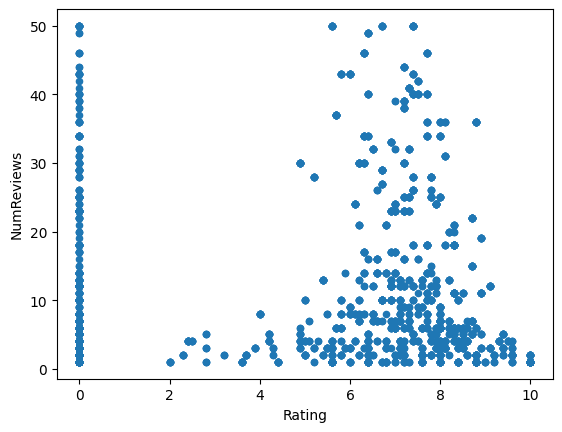

In [17]:
fix_df.plot.scatter(x='Rating', y='NumReviews')
# Display the plot
plt.show()

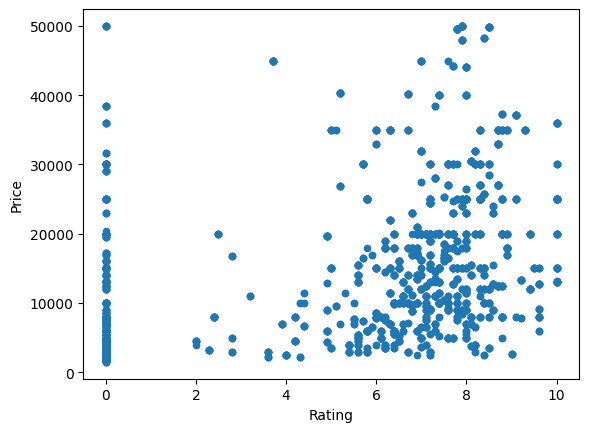

In [18]:
fix_df.plot.scatter(x='Rating', y='Price')
# Display the plot
plt.show()

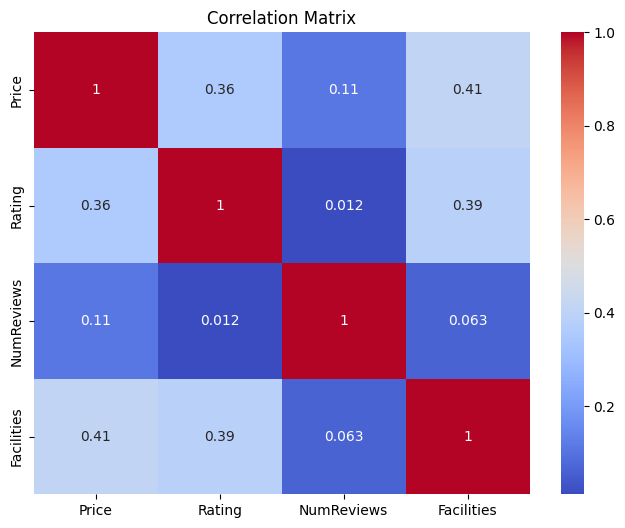

In [19]:
df = pd.DataFrame(fix_df)

# Menghitung matriks korelasi
corr_matrix = df.corr()

# Membuat plot heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

### Beberapa kode di atas merupakan visualisasi data setelah dilakukan *data preprocessing*, dapat dilihat bahwa Rating, NumReviews, dan Facilities memiliki korelasi terhadap harga, hal itu dapat dilihat korelasi ketiganya dnegna harga > 0.5

In [20]:
col = fix_df.pop('Price') 
y = pd.DataFrame(col)
X = fix_df.copy()
X

,Location,Rating,NumReviews,Facilities
0,Stokol,7.8,10,3
1,Machlessvile,5.6,4,3
2,Wanderland,7.2,38,4
3,Uberlandia,7.3,6,2
4,Stokol,7.2,30,2
...,...,...,...,...
3061,Andeman,0.0,3,2
3062,Uberlandia,8.1,4,3
3063,Willsmian,6.7,10,3
3064,Hallerson,0.0,10,1


### Kode di atas akan memisahkan 'Price' kembali pada variabel 'y' dan sisanya akan disimpan pada variabel 'X'

# Data Preprocessing on Test Data

In [21]:
testData

,ID,facilities,rating,location
0,0,GymrestaurantbarInternetSwimmingPools,8.0 ExcellentFrom 1 reviews,Stokol
1,1,Poolrestaurantgyminternetbar,7.4 Very GoodFrom 22 reviews,Hallerson
2,2,BARSwimmingPoolsInternetgym,0.0 FairFrom 4 reviews,Hallerson
3,3,gymSwimmingPoolsBARintrnetRestaurant,6.8 Very GoodFrom 13 reviews,Andeman
4,4,gymRestaurantpoolbarintrnet,0.0 FairFrom 9 reviews,Hallerson
...,...,...,...,...
762,762,BARPoolRestaurantGym,8.1 ExcellentFrom 9 reviews,Andeman
763,763,intrnetGympoolrestaurantBar,8.0 ExcellentFrom 4 reviews,Wanderland
764,764,RestaurantgymintrnetBARswimmingpools,7.4 Very GoodFrom 19 reviews,Andeman
765,765,gymInternetBarpoolRestaurant,9.0 ExcellentFrom 17 reviews,Hallerson


In [22]:
# Mengambil angka terdepan pada kolom rating dengan bantuan regex
testData['Rating'] = testData['rating'].str.extract(r'(\d+\.\d)')

#  Mengambil angka pada kolom rating dengan bantuan regex
testData['NumReviews'] = testData['rating'].str.extract(r'(\d+) review')
    
# Menghitung jumlah fasilitas yang ada
testData['Restaurant'] = testData['facilities'].str.lower().str.contains('res').astype(int)
testData['Internet'] = testData['facilities'].str.lower().str.contains('net').astype(int)
testData['Bar'] = testData['facilities'].str.lower().str.contains('bar').astype(int)
testData['Pool'] = testData['facilities'].str.lower().str.contains('pool').astype(int)
testData['Gym'] = testData['facilities'].str.lower().str.contains('gym').astype(int)
testData['Facilities'] = testData[['Restaurant', 'Internet', 'Bar', 'Pool', 'Gym']].sum(axis=1)

# Drop kolom yang tidak terpakai
testData = testData.drop(['facilities', 'rating', 'ID', 'facilities', 'Restaurant', 'Internet', 'Bar', 'Pool', 'Gym'], axis=1)

# Mengubah tipe data serta melakukan rename pada kolom agar penamaannya konsisten
testData['Rating'] = testData['Rating'].astype('Float64')
testData['NumReviews'] = testData['NumReviews'].astype('Int64')
testData['location'] = testData['location'].astype('category')
testData = testData.rename(columns={'location': 'Location'})

In [23]:
testData.describe()

,Rating,NumReviews,Facilities
count,767.0,767.0,767.000000
mean,5.79322,12.568449,4.885267
std,3.220643,7.223055,0.318907
min,0.0,1.0,4.000000
25%,5.05,6.0,5.000000
50%,7.1,12.0,5.000000
75%,8.0,19.0,5.000000
max,10.0,25.0,5.000000


# One Hot Encoding
### One Hot Encoding = mengubah data kategori menjadi kolom baru yang berisi nilai biner sesuai dengan data yang ada. Hal ini dilakukan agar model dapat lebih baik mempelajari suatu dataset

In [24]:
X = pd.get_dummies(X, columns=['Location'])
testData = pd.get_dummies(testData, columns=['Location'])

# Final Check

In [25]:
X

,Rating,NumReviews,Facilities,Location_Andeman,Location_Hallerson,Location_Machlessvile,Location_Stokol,Location_Uberlandia,Location_Ubisville,Location_Wanderland,Location_Willsmian
0,7.8,10,3,0,0,0,1,0,0,0,0
1,5.6,4,3,0,0,1,0,0,0,0,0
2,7.2,38,4,0,0,0,0,0,0,1,0
3,7.3,6,2,0,0,0,0,1,0,0,0
4,7.2,30,2,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3061,0.0,3,2,1,0,0,0,0,0,0,0
3062,8.1,4,3,0,0,0,0,1,0,0,0
3063,6.7,10,3,0,0,0,0,0,0,0,1
3064,0.0,10,1,0,1,0,0,0,0,0,0


In [26]:
testData

,Rating,NumReviews,Facilities,Location_Andeman,Location_Hallerson,Location_Machlessvile,Location_Stokol,Location_Uberlandia,Location_Ubisville,Location_Wanderland,Location_Willsmian
0,8.0,1,5,0,0,0,1,0,0,0,0
1,7.4,22,5,0,1,0,0,0,0,0,0
2,0.0,4,4,0,1,0,0,0,0,0,0
3,6.8,13,5,1,0,0,0,0,0,0,0
4,0.0,9,5,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
762,8.1,9,4,1,0,0,0,0,0,0,0
763,8.0,4,5,0,0,0,0,0,0,1,0
764,7.4,19,5,1,0,0,0,0,0,0,0
765,9.0,17,5,0,1,0,0,0,0,0,0


In [27]:
y

,Price
0,13500
1,13000
2,19000
3,6000
4,20000
...,...
3061,31625
3062,30500
3063,14000
3064,8500


# Split Dataset into Train and Test Set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model (Support Vector Regression)

In [29]:
from sklearn.svm import SVR
model = SVR(kernel = 'linear')
model.fit(X, y)

SVR(kernel='linear')

In [30]:
y_pred = model.predict(X_test)

# evaluasi model menggunakan mean squared error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 6914.973401583819


# Submission

In [31]:
submission = model.predict(testData)
submission_df = pd.DataFrame(submission)

In [32]:
submission_format['Price'] = submission_df

In [33]:
submission_format

,ID,Price
0,0,14871.362991
1,1,17204.588334
2,2,7557.528474
3,3,15456.628010
4,4,9025.842647
...,...,...
762,762,15251.158758
763,763,15277.884390
764,764,16789.980092
765,765,17914.545855


In [34]:
submission_format.to_csv('submission.csv',index = False)